# Loan Approval Prediction Algorithm

In [1]:
import pandas as pd

In [2]:
train_df  = pd.read_csv('./Dataset.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [3]:
# Droping Loan_ID 
train_df = train_df.drop(columns=['Loan_ID'])

In [4]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
print(categorical_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History', 'Loan_Amount_Term']


In [5]:
numerical_columns = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
print(numerical_columns)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [6]:
# Data Visualization Part
import seaborn as sns
import matplotlib.pyplot as plt

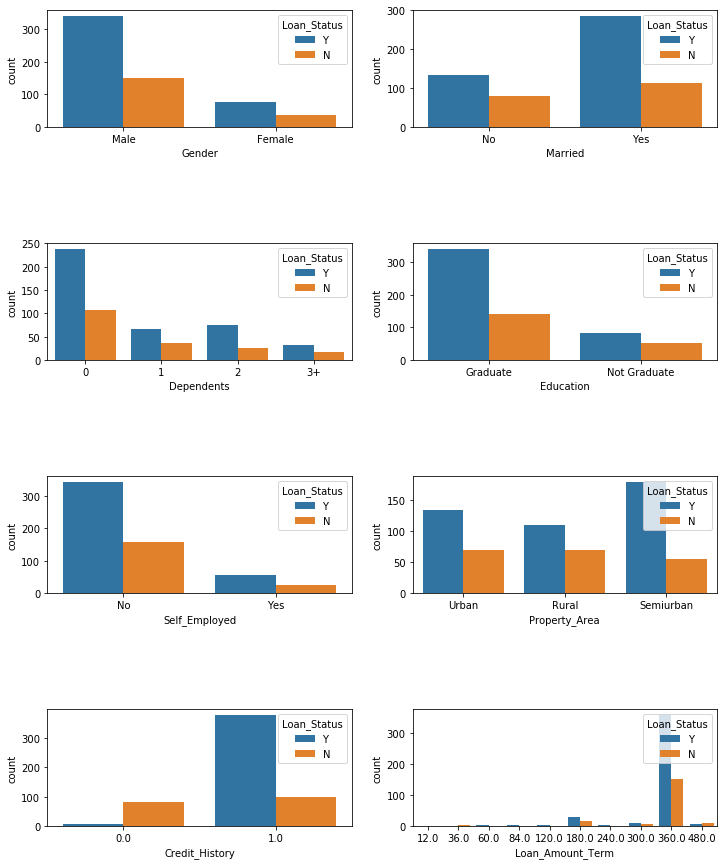

In [7]:
#Now, let's analyze Categorical Columns:
fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train_df,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=1)

       ApplicantIncome  CoapplicantIncome  LoanAmount
count       614.000000         614.000000  592.000000
mean       5403.459283        1621.245798  146.412162
std        6109.041673        2926.248369   85.587325
min         150.000000           0.000000    9.000000
25%        2877.500000           0.000000  100.000000
50%        3812.500000        1188.500000  128.000000
75%        5795.000000        2297.250000  168.000000
max       81000.000000       41667.000000  700.000000


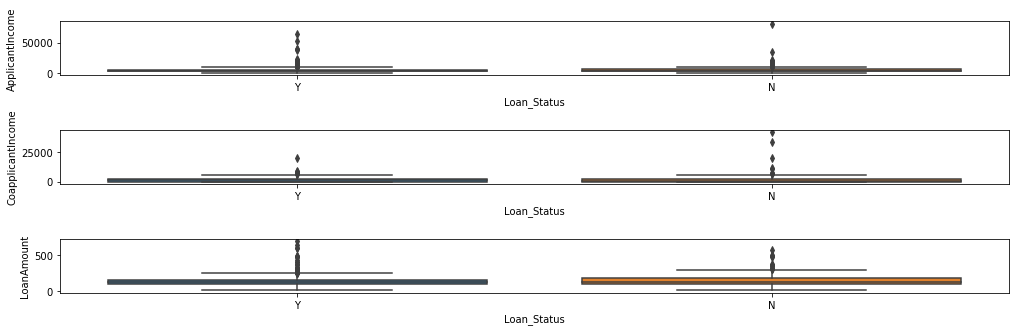

In [8]:
#Now, let's also analyze Numerical Columns:
fig,axes = plt.subplots(3,1,figsize=(17,5))
for idx,cat_col in enumerate(numerical_columns):
    sns.boxplot(y=cat_col,data=train_df,x='Loan_Status',ax=axes[idx])
    
print(train_df[numerical_columns].describe())
plt.subplots_adjust(hspace=1)

# Processing Data

In [9]:
#Encoding Categorical data 
train_df_encoded = pd.get_dummies(train_df,drop_first=True) # Add dummy variable into dataframe
train_df_encoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,NaN,360.0,1.0,1,0,0,0,0,0,0,0,1,1
1,4583,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,1,0,1,1
3,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,1,0,0,1,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,0,0,0,1,1


In [10]:
#Split features and  Target variable 
X = train_df_encoded.drop(columns='Loan_Status_Y') # remove column Loan_Status_Y
y = train_df_encoded['Loan_Status_Y']
#print(X)
#print(y)

In [11]:
# Splitting into Train -Test Data

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [12]:
# Handling/Imputing Missing values

from sklearn.impute import SimpleImputer # it helps to fill missing value using other data mean 
imp = SimpleImputer(strategy='mean')
imp_train = imp.fit(X_train)
X_train = imp_train.transform(X_train)
X_test_imp = imp_train.transform(X_test)

# Decision Tree Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score , f1_score


tree_clf= DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)

print("Training Data Set accuracy :- ",accuracy_score(y_train,y_pred))
print("Training Data F1 Score :-",f1_score(y_train,y_pred))
print("Validation F1 Mean Score:- ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Accuracy  Score:- ",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data Set accuracy :-  1.0
Training Data F1 Score :- 1.0
Validation F1 Mean Score:-  0.6451230699949734
Validation Accuracy  Score:-  0.6986473189713248


--> Overfitting Problem
We can see from above metrics that Training Accuracy > Test Accuracy with default settings of Decision Tree classifier. Hence, model is overfit. We will try some Hyper-parameter tuning and see if it helps.

First let's try tuning 'Max_Depth' of tree

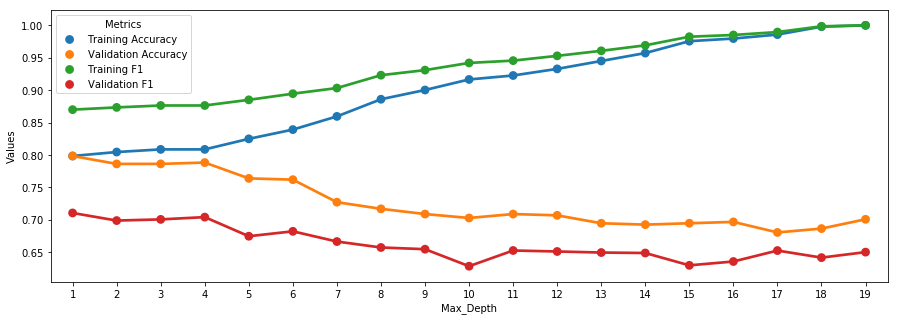

In [14]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths = []

for depth in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    

Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)

plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)
    

From above graph, we can conclude that keeping 'Max_Depth' = 3 will yield optimum Test accuracy and F1 score Optimum Test Accuracy ~ 0.805; Optimum F1 Score: ~0.7

Visulazing Decision Tree with Max Depth = 3

In [15]:
!pip install graphviz

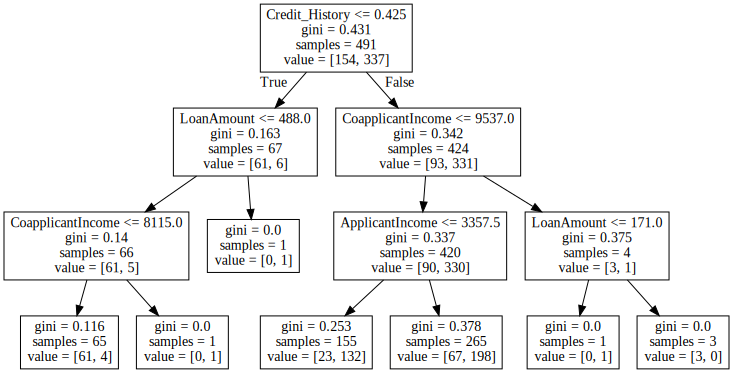

In [16]:
import graphviz 
from sklearn import tree

tree_clf = tree.DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(X_train,y_train)
dot_data = tree.export_graphviz(tree_clf,feature_names = X.columns.tolist())
graph = graphviz.Source(dot_data)
graph

From above tree, we could see that some of the leafs have less than 5 samples hence our classifier might overfit. We can sweep hyper-parameter 'min_samples_leaf' to further improve test accuracy by keeping max_depth to 3

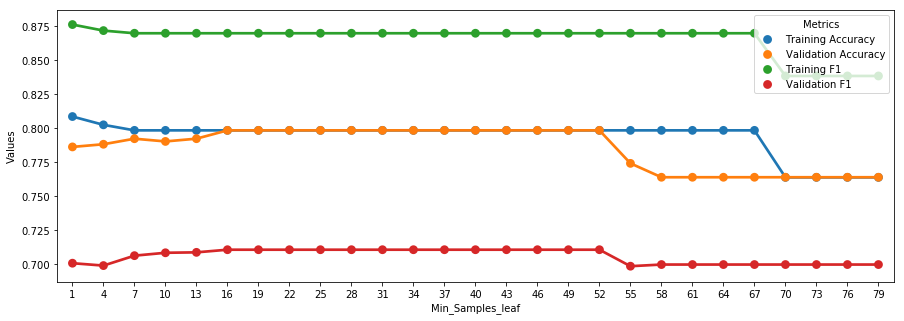

In [17]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []

import numpy as np # import numpy for numeric calculation
for samples_leaf in range(1,80,3): #Sweeping from 1% samples to 10% samples per leaf 
    tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)

    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    

Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)

From above plot, we will choose Min_Samples_leaf to 35 to improve test accuracy.

Let's use this Decision Tree classifier on unseen test data and evaluate Test Accuracy, F1 Score and Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test_imp)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8536585365853658
Test F1 Score:  0.903225806451613
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,21,17,38
1,1,84,85
All,22,101,123


It can be seen that majority of the misclassifications are happening because of Loan Reject applicants being classified as Accept.

#  Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators = 100,max_depth = 3 ,min_samples_leaf=10)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_train)

print("Train F1 Score:- ",f1_score(y_train,y_pred))
print("Train Accuracy :- ",accuracy_score(y_train,y_pred))
print("Validation Mean F1 Score:- ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean F1 Score:- ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy').mean())


Train F1 Score:-  0.8699080157687253
Train Accuracy :-  0.7983706720977597
Validation Mean F1 Score:-  0.7104522093151318
Validation Mean F1 Score:-  0.7922194807319991


# Random Forest: Test Data Evaluation


In [20]:
y_pred = rf_clf.predict(X_test_imp)
print("Test score accuracy :- ",accuracy_score(y_test,y_pred))
print("Test F1 score:- ",f1_score(y_test,y_pred))
print("Confusion metrix on test data:-")
pd.crosstab(y_test,y_pred,rownames=["True"],colnames=["Predicted"],margins= True)


Test score accuracy :-  0.8536585365853658
Test F1 score:-  0.903225806451613
Confusion metrix on test data:-


Predicted,0,1,All
True,,,
0,21,17,38
1,1,84,85
All,22,101,123


It can be clearly seen that same result found in this model so we will  try other model which is called Logistic regression and try to get better accuracy.

# Logistic Regression Model 

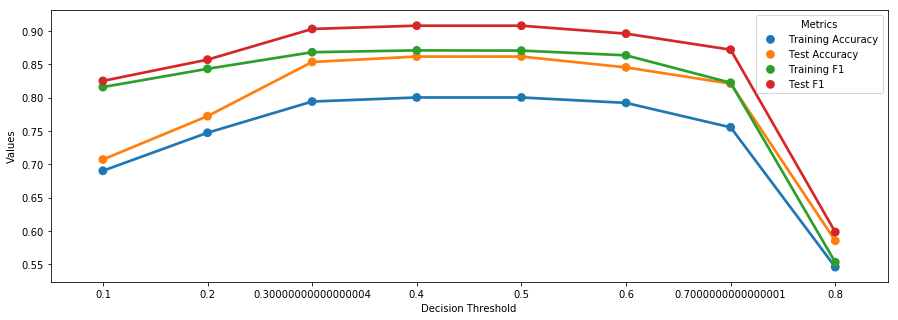

In [23]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

train_accuracies = []
train_f1_scores =[]
test_accuracies = []
test_f1_scores =[]
thresholds = []

#for thresh in np.linspace(0.1,0.9,8): ## Sweeping from threshold of 0.1 to 0.9
for thresh in np.arange(0.1,0.9,0.1):## Sweeping from threshold of 0.1 to 0.9
    
    lr_clf = LogisticRegression(solver='liblinear')
    lr_clf.fit(X_train,y_train)
    
    y_pred_train_thresh = lr_clf.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)
    
    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = lr_clf.predict_proba(X_test_imp)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh ).astype(int)
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)

Logistic Regression does slightly better than Decision Tree and Random Forest.
Based on the above Test/Train curves, we can keep threshold to 0.4.
Now Finally let's look at Logistic Regression Confusion Matrix

In [25]:
thresh = 0.4 ### Threshold chosen from above Curves

y_pred_test_thresh = lr_clf.predict_proba(X_test_imp)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8617886178861789
Test F1 Score:  0.9081081081081082
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,22,16,38
1,1,84,85
All,23,100,123


Logistic Regression Confusion matrix is very similar to Decision Tree and Random Forest Classifier. In this analysis, we did extensive analysis of input data and were able to achieve Test Accuracy of 86 %